In [227]:
import pandas as pd 
import seaborn as sns
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import networkx as nx
import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import multiprocessing as mp
from multiprocessing import cpu_count
import pickle
#mp.set_start_method('spawn')
from myfunctions import extract_freqs, calc_iter #custom functions

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from scipy.stats import entropy
from littleballoffur import BreadthFirstSearchSampler, \
                            PageRankBasedSampler, \
                            CommunityStructureExpansionSampler, \
                            MetropolisHastingsRandomWalkSampler, \
                            RandomWalkSampler, \
                            RandomNodeNeighborSampler, \
                            CommonNeighborAwareRandomWalkSampler

# __Cell to compile gtscanner__
You should just execute make in gtscanner directory

We have some set of datasets

In [2]:
path_to_datasets = '../datasets/'
path_to_uniform_data = '../data/'
path_to_output = '../output/'
path_to_samples = '../samples/'

functions

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Reading datasets

In [ ]:
def read_graph_data(filename, sep=',', header=None, skiprows=0):
    edgelist = pd.read_csv(os.path.join(path_to_datasets, filename), sep=sep, skiprows=skiprows, header=header, names=['source', 'target'])
    edgelist.to_csv(os.path.join(path_to_uniform_data, filename), index=False, header=None)
    return nx.from_pandas_edgelist(edgelist)

Ячейку нижу можно не запускать

In [94]:
citeseer = read_graph_data('citeseer.cites', sep='\t')
deezer_europe = read_graph_data('deezer_europe_edges.csv', header=0)
lastfm_asia = read_graph_data('lastfm_asia_edges.csv', header=0)
cora = read_graph_data('cora.cites', sep='\t')
email_Eu_core = read_graph_data('email-Eu-core.txt', sep=' ')
fb_0 = read_graph_data('0.edges', sep=' ')
fb_1 = read_graph_data('107.edges', sep=' ')
fb_2 = read_graph_data('348.edges', sep=' ')
fb_3 = read_graph_data('414.edges', sep=' ')
fb_4 = read_graph_data('686.edges', sep=' ')
fb_5 = read_graph_data('698.edges', sep=' ')
fb_6 = read_graph_data('1684.edges', sep=' ')
fb_7 = read_graph_data('1912.edges', sep=' ')
fb_8 = read_graph_data('3437.edges', sep=' ')
fb_9 = read_graph_data('3980.edges', sep=' ')
email_univ = read_graph_data('email-univ.edges', sep=' ')
fb_company = read_graph_data('fb-pages-company.edges', header=0)
fb_food = read_graph_data('fb-pages-food.edges')
fb_politician = read_graph_data('fb-pages-politician.edges')
fb_public_figure = read_graph_data('fb-pages-politician.edges')
fb_tvshow = read_graph_data('fb-pages-tvshow.edges')
soc_anybeat = read_graph_data('soc-anybeat.edges', sep=' ')
soc_hamsterster = read_graph_data('soc-hamsterster.edges', sep=' ', skiprows=2)
soc_wiki_vote = read_graph_data('soc-wiki-Vote.mtx', sep=' ', skiprows=2)
cit_DBLP = read_graph_data('cit-DBLP.edges', sep=' ', skiprows=2)

# list_of_graphs = [citeseer, deezer_europe, lastfm_asia, cora, email_Eu_core,
#                   fb_0, fb_1, fb_2, fb_3, fb_4, fb_5, fb_6, fb_7, fb_8, fb_9,
#                   email_univ, fb_company, fb_food, fb_politician, fb_public_figure,
#                   fb_tvshow, soc_anybeat, soc_hamsterster, soc_wiki_vote, cit_DBLP]
# len(list_of_graphs)

## Graph classification dataset for benchmark

In [10]:
%cd ../datasets/
!wget http://nrvis.com/download/data/labeled/REDDIT-BINARY.zip
!wget http://nrvis.com/download/data/labeled/COLLAB.zip
!unzip REDDIT-BINARY.zip
!unzip COLLAB.zip
%cd ../notebooks/

/Users/zaikoval/Documents/GitHub/regression-on-sampling/datasets
--2020-08-30 16:02:21--  http://nrvis.com/download/data/labeled/REDDIT-BINARY.zip
Распознаётся nrvis.com (nrvis.com)… 173.236.156.25
Подключение к nrvis.com (nrvis.com)|173.236.156.25|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 9924710 (9,5M) [application/zip]
Сохранение в: «REDDIT-BINARY.zip»

REDDIT-BINARY.zip   100%[===================>]   9,46M  2,08MB/s    за 7,7s    

2020-08-30 16:02:29 (1,23 MB/s) - «REDDIT-BINARY.zip» сохранён [9924710/9924710]

Archive:  REDDIT-BINARY.zip
  inflating: REDDIT-BINARY.edges     
  inflating: readme.html             
  inflating: REDDIT-BINARY.graph_idx  
  inflating: REDDIT-BINARY.graph_labels  
  inflating: REDDIT-BINARY.readme    
/Users/zaikoval/Documents/GitHub/regression-on-sampling/notebooks


In [5]:
edges = pd.read_csv(os.path.join(path_to_datasets, 'REDDIT-BINARY.edges'), header=None, names=['source', 'target'])

In [6]:
full_graph = nx.from_pandas_edgelist(edges)

In [7]:
graph_idx = pd.read_csv(os.path.join(path_to_datasets, 'REDDIT-BINARY.graph_idx'), header=None)

In [8]:
graphs = list()
for i in tqdm(graph_idx[0].unique()):
    set_of_nodes = graph_idx[graph_idx[0] == i].index + 1
    subgraph = nx.subgraph(full_graph, set_of_nodes)
    connected_subgraph = nx.subgraph(full_graph, max(nx.connected_components(subgraph), key=len)) #extract max connected subgraph
    graphs.append(connected_subgraph)

In [15]:
graphs = graphs[:200] # take only part of graphs to make it faster

## Compute number of iterations
Можно не запускать, так как ниже есть сохраненный файл для 200 графов

In [20]:
parellel = False # change to True to compute in parallel
chunksize = 6 # vary this value to speedup parallel computation

iterations = [] 

if parellel:
    with mp.Pool(cpu_count()) as p:
        iterations = list(tqdm(p.imap(calc_iter, graphs, chunksize=chunksize), total=len(graphs)))
else:
    for elem in tqdm(graphs):
        iterations.append(calc_iter(elem))
        
#pd.DataFrame(iterations).to_csv(os.path.join(path_to_output, 'ndlib/ndlib.csv'), index=False, header=None)

/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "
/home/zaikoval/anaconda3/lib/python3.7/site-packages/ndlib/models/DiffusionModel.py:170: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  "The fraction_infected value is too low given the number of nodes of the selected graph: a "


In [410]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

num_cores = mp.cpu_count()
processed_list = Parallel(n_jobs=num_cores)(delayed(calc_iter)(i) for i in tqdm(graphs))

 20%|██        | 40/200 [01:01<04:13,  1.59s/it]

KeyboardInterrupt: 

In [20]:
ndl_data = pd.read_csv(os.path.join(path_to_output, 'ndlib/ndlib.csv'), header=None)
ndl_data

,0
0,32.9
1,40.2
2,45.9
3,38.3
4,41.6
...,...
195,38.0
196,47.4
197,38.3
198,45.7


## Compute motif distribution for graphs
Также можно не запускать, ниже готовый файл для 200 графов

In [408]:
freqs = []
for item in tqdm(graphs): 
    freqs.append(extract_freqs(item, size=4, random=10)) #already in parallel
#pd.DataFrame(freqs).to_csv(os.path.join(path_to_output, 'freqs.csv'), index=False, header=None)
# pay attention to the available parameters in extract_freqs function

KeyboardInterrupt: 

In [294]:
freqs_data = pd.read_csv(os.path.join(path_to_output, 'freqs.csv'), header=None)
freqs_data

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.023235,0.000034,0.974224,0.002493,0.000014,0.0,0.046806,-0.020803,0.655286,-0.669154,-0.346712,0.0
1,0.008805,0.000022,0.990187,0.000983,0.000003,0.0,-0.372722,0.196123,0.610110,-0.619428,-0.258243,0.0
2,0.037216,0.000047,0.956137,0.006533,0.000067,0.0,-0.424974,-0.163452,0.572081,-0.578891,-0.360956,0.0
3,0.015102,0.000026,0.982784,0.002080,0.000009,0.0,0.010402,0.093621,0.633388,-0.638012,-0.427653,0.0
4,0.019005,0.000057,0.979387,0.001545,0.000005,0.0,-0.640980,-0.016075,0.501331,-0.516401,-0.266238,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.033012,0.000077,0.962028,0.004842,0.000040,0.0,0.285519,0.042190,0.616171,-0.630889,-0.372842,0.0
196,0.244257,0.001288,0.748766,0.005635,0.000054,0.0,0.347243,0.046867,0.592231,-0.619925,-0.377068,0.0
197,0.025558,0.000049,0.972453,0.001935,0.000005,0.0,-0.520757,-0.062980,0.552717,-0.555537,-0.332758,0.0
198,0.026766,0.000060,0.971582,0.001587,0.000005,0.0,-0.366340,-0.057350,0.609786,-0.620320,-0.325376,0.0


Возможно стоит добавить несколько графов из [IMDB](http://nrvis.com/download/data/labeled/IMDB.zip) и [COLLAB](http://nrvis.com/download/data/labeled/COLLAB.zip) datasets

## Regression quality metrics on motif ditsribution of original graph 

In [295]:
freqs_data['ndlib'] = ndl_data[0]
freqs_data

,0,1,2,3,4,5,6,7,8,9,10,11,ndlib
0,0.023235,0.000034,0.974224,0.002493,0.000014,0.0,0.046806,-0.020803,0.655286,-0.669154,-0.346712,0.0,32.9
1,0.008805,0.000022,0.990187,0.000983,0.000003,0.0,-0.372722,0.196123,0.610110,-0.619428,-0.258243,0.0,40.2
2,0.037216,0.000047,0.956137,0.006533,0.000067,0.0,-0.424974,-0.163452,0.572081,-0.578891,-0.360956,0.0,45.9
3,0.015102,0.000026,0.982784,0.002080,0.000009,0.0,0.010402,0.093621,0.633388,-0.638012,-0.427653,0.0,38.3
4,0.019005,0.000057,0.979387,0.001545,0.000005,0.0,-0.640980,-0.016075,0.501331,-0.516401,-0.266238,0.0,41.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.033012,0.000077,0.962028,0.004842,0.000040,0.0,0.285519,0.042190,0.616171,-0.630889,-0.372842,0.0,38.0
196,0.244257,0.001288,0.748766,0.005635,0.000054,0.0,0.347243,0.046867,0.592231,-0.619925,-0.377068,0.0,47.4
197,0.025558,0.000049,0.972453,0.001935,0.000005,0.0,-0.520757,-0.062980,0.552717,-0.555537,-0.332758,0.0,38.3
198,0.026766,0.000060,0.971582,0.001587,0.000005,0.0,-0.366340,-0.057350,0.609786,-0.620320,-0.325376,0.0,45.7


In [23]:
for i, g in enumerate(graphs):
    n = g.number_of_nodes()
    e = g.number_of_edges()
    freqs_data.loc[i, 'nodes'] = n
    freqs_data.loc[i, 'edges'] = e
    freqs_data.loc[i, 'density'] = 2*e/(n*(n-1))

In [347]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(r2_score)).mean()

-0.05481361216458974

In [356]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(mean_absolute_percentage_error)).mean()

8.428257141205675

In [25]:
# from sklearn.linear_model import LinearRegression
# cross_val_score(LinearRegression(),
#                 X=freqs_data.drop('ndlib', axis=1),
#                 y=freqs_data['ndlib'], cv=4, scoring=make_scorer(r2_score)).mean()

Quality isn't that good. We should change the dataset or add 5-motifs features

## Sampling

In [274]:
def graph_sampling(method, n_graphs=10, n_seeds=5): #подавать сюда лист графов для расчёта 
    list_of_samples_data = []
    for idx_g, G in enumerate(tqdm(graphs[:n_graphs])):

        G_num_nodes = G.number_of_nodes()
        G_num_edges = G.number_of_edges()
        G = nx.convert_node_labels_to_integers(G)
        G_freqs = np.array(extract_freqs(G, 4)) #можно брать из прошлой таблицы
        G_density = 2*G_num_edges/(G_num_nodes*(G_num_nodes-1))

        for idx_part, part in enumerate(range(1,10)): # сэмплим от 10% до 90%

            sampled_part_of_nodes = int(G_num_nodes*part/10)

            percentage_sampled = sampled_part_of_nodes / G_num_nodes

            for seed in range(174,n_seeds+175):

                model = method(sampled_part_of_nodes, seed=seed)
                sample = model.sample(G)
                sample = nx.subgraph(G, max(nx.connected_components(sample), key=len)) #max connected component

                sample_freqs = np.array(extract_freqs(sample, 4))

                sample_num_nodes = sample.number_of_nodes()
                sample_num_edges = sample.number_of_edges()

                sample_density = 2*sample_num_edges/(sample_num_nodes*(sample_num_nodes-1))

                rel_density = sample_density / G_density

                KL_divergence = entropy(G_freqs, sample_freqs)

                list_of_samples_data.append((idx_g, percentage_sampled, seed, KL_divergence, rel_density))

    KLD = pd.DataFrame(list_of_samples_data, columns=['idx_g', 'nodes', 'seed', 'KL', 'rel dens'])
    KLD['rounded_nodes'] = np.round(KLD_data.nodes, decimals=2)

    return KLD

def plot_KLD(KLD, name):
    
    plt.figure(figsize=(20,6));
    plt.suptitle(name, fontsize=22)
    plt.subplot(121);
    g1 = sns.boxplot(x='rounded_nodes',y='KL', data=KLD);
    g1.set_yscale('log');
    plt.subplot(122);
    g2 = sns.scatterplot(x='rounded_nodes',
                         y='KL',
                         data = KLD[KLD.KL != np.inf].groupby('rounded_nodes').KL.mean().reset_index())
    g2.set_yscale('log');
    

In [237]:
methods = [(CommunityStructureExpansionSampler, 'Community Structure Expansion Sampler'),
           (MetropolisHastingsRandomWalkSampler, 'Metropolis Hastings RandomWalk Sampler'),
           (BreadthFirstSearchSampler, 'Breadth First Search Sampler'),
             (PageRankBasedSampler, 'Page Rank Based Sampler'),
             (RandomWalkSampler, 'Random Walk Sampler'),
             (CommonNeighborAwareRandomWalkSampler, 'Common Neighbor Aware RandomWalk Sampler')]

In [241]:
KDLs = []
for method, name in tqdm(methods):
    KDL = graph_sampling(method)
    KDLs.append(KDL)

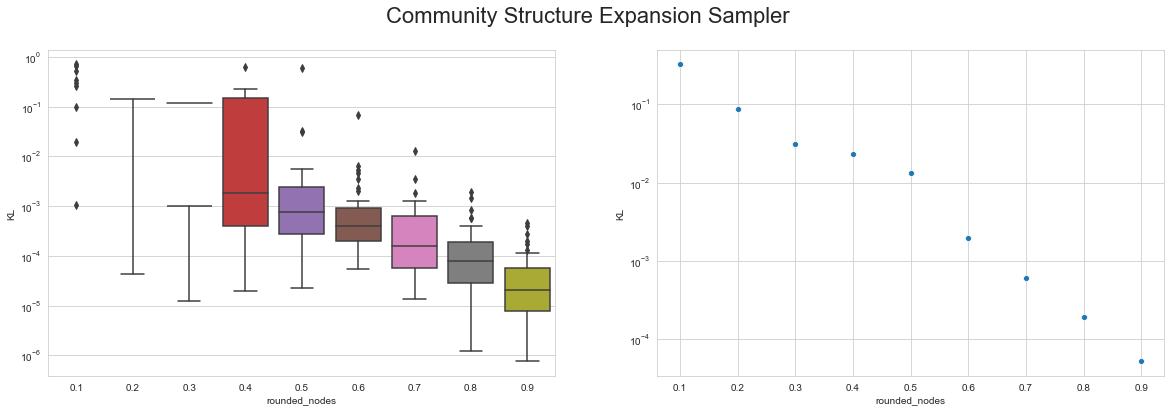

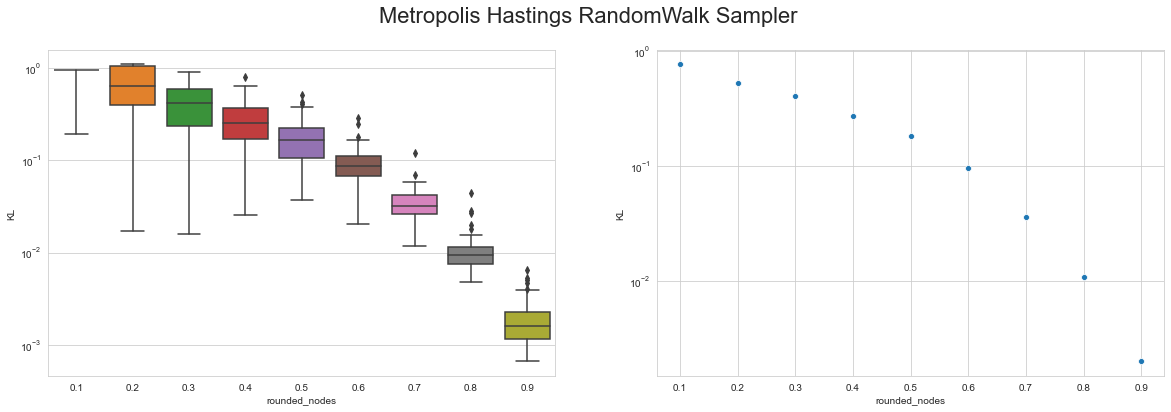

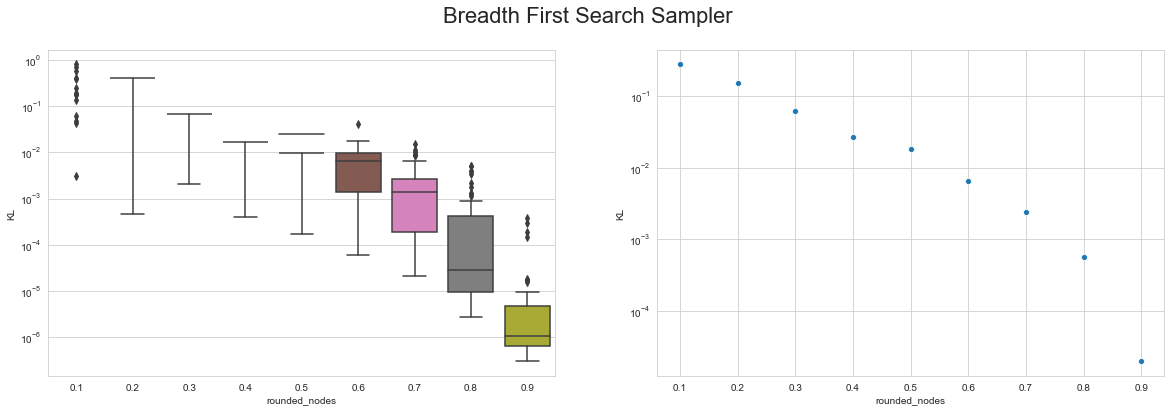

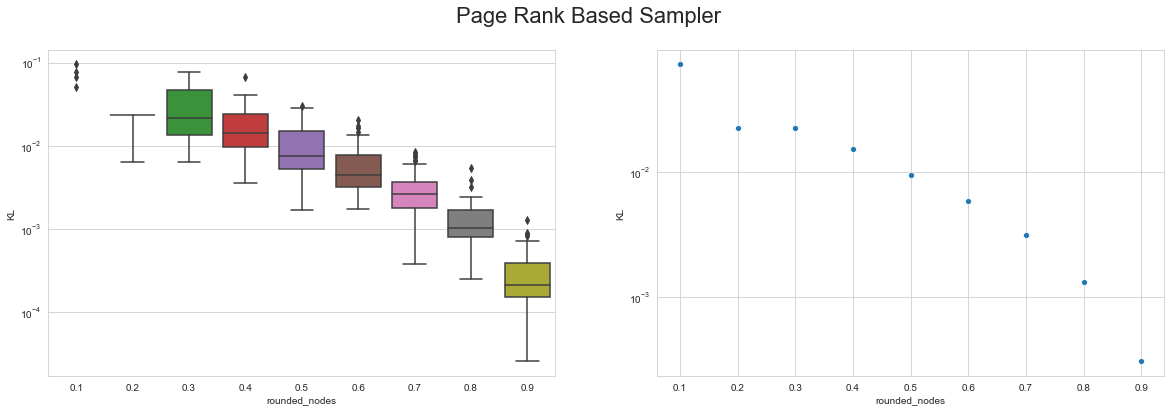

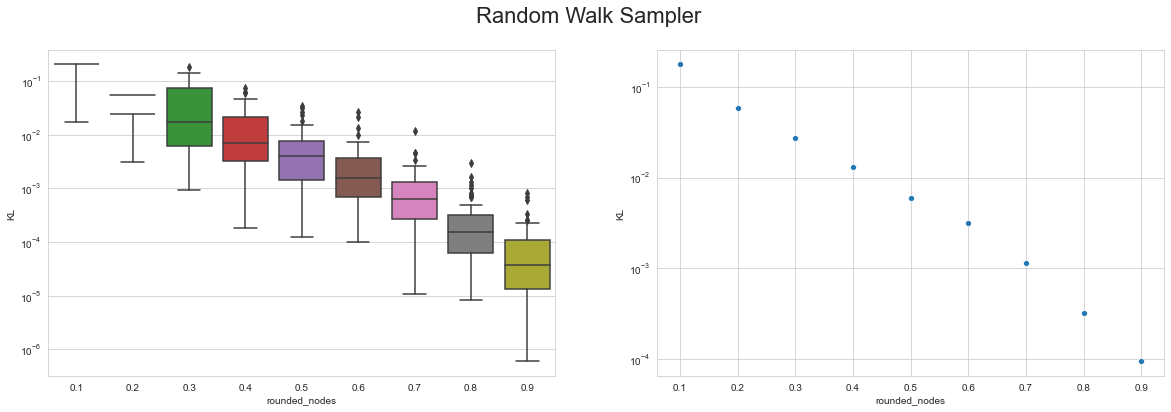

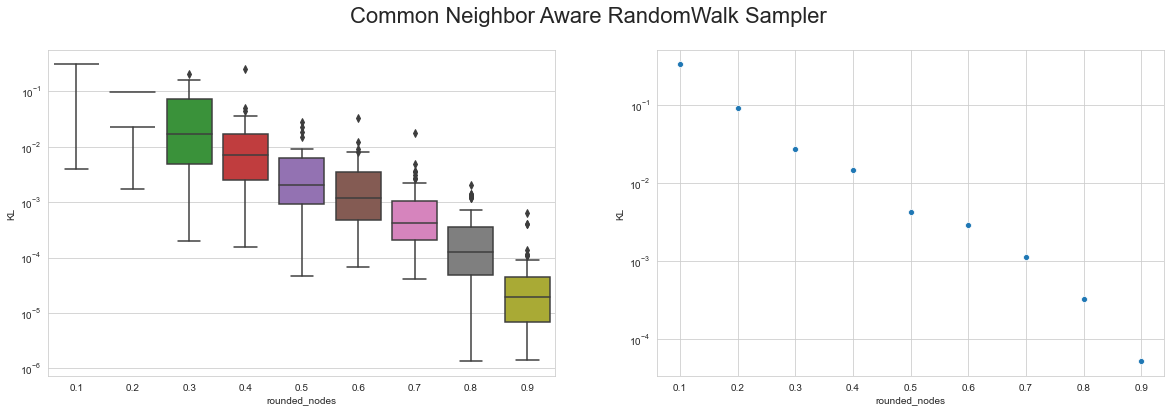

In [269]:
for LDK, name in list(zip(KDLs, methods)):
    plot_KLD(LDK, name[1])

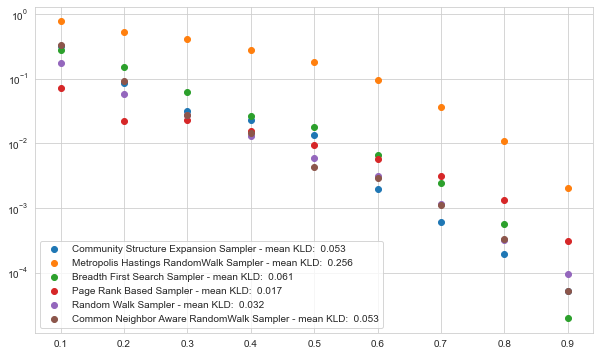

In [291]:
plt.figure(figsize=(10,6))
mean_KLDs = []
for KLD in KDLs:
    test = KLD[KLD.KL != np.inf].groupby('rounded_nodes').KL.mean().reset_index()
    ax = plt.scatter(x=test.rounded_nodes, y=test.KL)
    plt.yscale('log')
    mean_KLDs.append(test.KL.mean())
    
plt.legend([x[0][1]+' - mean KLD:  '+str(np.round(x[1], decimals=3)) for x in zip(methods, mean_KLDs)])

Decide sampling method and percentage we want to take and sample it

In [382]:
method = PageRankBasedSampler
percentage = 0.7
seed = 456

list_of_samples_data = []
for G in tqdm(graphs):
    G_num_nodes = G.number_of_nodes()
    G_num_edges = G.number_of_edges()
    G = nx.convert_node_labels_to_integers(G)
    G_density = 2*G_num_edges/(G_num_nodes*(G_num_nodes-1))
    
    sampled_part_of_nodes = int(G_num_nodes*percentage)
    
    model = method(sampled_part_of_nodes, seed=seed)
    sample = model.sample(G)
    sample = nx.subgraph(G, max(nx.connected_components(sample), key=len)) #max connected component
    
    sample_freqs = np.array(extract_freqs(sample, 4, random=10))
    
    list_of_samples_data.append(sample_freqs)

In [403]:
df = pd.DataFrame(list_of_samples_data)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.036355,0.000100,0.958922,0.004578,0.000045,0.0,-0.038501,0.005500,0.658176,-0.671010,-0.339172,0.0
1,0.013610,0.000046,0.984480,0.001855,0.000010,0.0,-0.503769,0.102314,0.546255,-0.549724,-0.367638,0.0
2,0.064099,0.000092,0.923834,0.011789,0.000185,0.0,-0.655477,-0.285664,0.458391,-0.471678,-0.236946,0.0
3,0.024095,0.000064,0.972127,0.003692,0.000021,0.0,0.127660,0.203458,0.628992,-0.631651,-0.384310,0.0
4,0.036487,0.000187,0.960284,0.003027,0.000014,0.0,-0.519656,0.129668,0.554038,-0.586455,-0.249513,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.046289,0.000209,0.944592,0.008809,0.000102,0.0,0.536757,0.141300,0.538592,-0.552355,-0.311044,0.0
196,0.336197,0.001562,0.650680,0.011404,0.000156,0.0,0.729121,-0.251191,0.417911,-0.433471,-0.206733,0.0
197,0.047712,0.000146,0.949546,0.002586,0.000010,0.0,-0.543661,0.013064,0.524567,-0.528587,-0.386894,0.0
198,0.049528,0.000181,0.946403,0.003868,0.000020,0.0,-0.372754,-0.033042,0.608178,-0.624699,-0.315963,0.0


In [384]:
ndl_data

,0
0,32.9
1,40.2
2,45.9
3,38.3
4,41.6
...,...
195,38.0
196,47.4
197,38.3
198,45.7


Check regression metrics

In [404]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(r2_score)).mean() #orig_data score again

-0.05481361216458974

In [405]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=df,
                y=ndl_data, cv=4, scoring=make_scorer(r2_score)).mean() #sampled_data score 

-0.0042400738606287736

In [406]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=freqs_data.drop('ndlib', axis=1),
                y=freqs_data['ndlib'], cv=4, scoring=make_scorer(mean_absolute_percentage_error)).mean()#orig_data score again

8.428257141205675

In [407]:
cross_val_score(CatBoostRegressor(iterations=100, silent=True),
                X=df,
                y=ndl_data, cv=4, scoring=make_scorer(mean_absolute_percentage_error)).mean() #sampled_data score 

9.506879891565353

Добавляем density and size and check metrics